In [115]:
import np as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.6f}".format

In [175]:
train_df = pd.read_csv(filepath_or_buffer=r'C:\Projects\Crosstalk\Machine_Learning\Data\2024-09-05_14-55\large_data.csv')
test_df = pd.read_csv(filepath_or_buffer="C:\Projects\Crosstalk\Machine_Learning\Data/2024-09-05_14-55/test.csv")
# validation_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/with_decay/no_j/no_j_1000.csv")

# train_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/all_expectation_values_100000.csv")
# test_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/all_expectation_values_100.csv")
# validation_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/all_expectation_values_10000.csv")
train_df.head()
print(len(train_df))

11000


In [176]:
class TrigonometricLayer(tf.keras.layers.Layer):
    def __init__(self, t, num_measurements, **kwargs):
        super(TrigonometricLayer, self).__init__(**kwargs)
        self.t = t  # Time at which measurements are taken
        self.num_measurements = num_measurements  # Number of measurement functions

    def build(self, input_shape):
        # Initialize trainable parameters

        self.trig_weights = self.add_weight(
            name='trig_weights',
            shape=(20, 8),
            initializer=tf.random_uniform_initializer(minval=0.0, maxval=1.0),
            trainable=True
        )

        super(TrigonometricLayer, self).build(input_shape)

    def call(self, inputs):
        # Compute each measurement function based on trainable parameters
        w0, w1, j, a1, a2 = inputs[:, 0], inputs[:, 1], inputs[:, 2], inputs[:, 3], inputs[:, 4]

        x1 = tf.cos(w0 * self.t) * tf.exp(- a1 * self.t)
        x2 = tf.cos(w1 * self.t) * tf.exp(- a1 * self.t)
        x3 = tf.cos(j * self.t) * tf.exp(- a1 * self.t)
        x4 = tf.sin(w0 * self.t) * tf.exp(- a1 * self.t)
        x5 = tf.sin(w1 * self.t) * tf.exp(- a1 * self.t)
        x6 = tf.sin(j * self.t) * tf.exp(- a1 * self.t)
        x7 = tf.cos((w0 + w1) * self.t) * tf.exp(- a1 * self.t)
        x8 = tf.cos((w0 + j) * self.t) * tf.exp(- a1 * self.t)
        x9 = tf.cos((w1 + j) * self.t) * tf.exp(- a1 * self.t)
        x10 = tf.cos((w1 + j + w0) * self.t) * tf.exp(- a1 * self.t)

        x11 = tf.cos(w0 * self.t) * tf.exp(- a2 * self.t)
        x12 = tf.cos(w1 * self.t) * tf.exp(- a2 * self.t)
        x13 = tf.cos(j * self.t) * tf.exp(- a2 * self.t)
        x14 = tf.sin(w0 * self.t) * tf.exp(- a2 * self.t)
        x15 = tf.sin(w1 * self.t) * tf.exp(- a2 * self.t)
        x16 = tf.sin(j * self.t) * tf.exp(- a2 * self.t)
        x17 = tf.cos((w0 + w1) * self.t) * tf.exp(- a2 * self.t)
        x18 = tf.cos((w0 + j) * self.t) * tf.exp(- a2 * self.t)
        x19 = tf.cos((w1 + j) * self.t) * tf.exp(- a2 * self.t)
        x20 = tf.cos((w1 + j + w0) * self.t) * tf.exp(- a2 * self.t)

        trig_combinations = tf.stack([
            x1, x2, x3, x4, x5, x6, x7, x8, x9, x10,
            x11, x12, x13, x14, x15, x16, x17, x18, x19, x20
        ], axis=-1)

        outputs = tf.matmul(trig_combinations, self.trig_weights)  # Shape: (1, num_features)

        return outputs

In [178]:
import tensorflow as tf

learning_rate = 0.0001
epochs = 1500
batch_size = 500

# Get all column names as a list
keys = train_df.keys().tolist()
# input_keys = ['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]
output_keys = ["decay_0", "decay_1", "decay_2", "decay_3", "W_0", "W_1", "W_2", "W_3", "J_0", "J_1", "J_2"]

output_keys = [key for key in keys if key not in input_keys]

inputs = {key: tf.keras.layers.Input(shape=(1,), name=key) for key in input_keys}
concatenated_inputs = tf.keras.layers.concatenate(list(inputs.values()))

# Prepare data for training
train_features = {key: train_df[key] for key in inputs}
train_labels = train_df[output_keys]

# Similarly prepare test and validation data
test_features = {key: test_df[key] for key in inputs}
test_labels = test_df[output_keys]


def build_model(input_layer, num_layers, nodes_per_layer=None, default_nodes=64):
    # If no list of nodes is provided, use the default number of nodes for all layers
    if nodes_per_layer is None:
        nodes_per_layer = [default_nodes] * num_layers

    # Check if nodes_per_layer has the correct number of layers
    assert len(nodes_per_layer) == num_layers, "Length of nodes_per_layer must match num_layers"

    # Build the hidden layers dynamically
    hidden_layer = input_layer
    for i in range(num_layers):
        hidden_layer = tf.keras.layers.Dense(nodes_per_layer[i], activation='relu')(hidden_layer)

    # Output layer (Assuming len(output_keys) is predefined)
    output = tf.keras.layers.Dense(len(output_keys))(hidden_layer)

    return output


nodes_per_layer = [32, 64, 64, 64, 64, 64, 64, 8]  # Optional, can be None
output = build_model(concatenated_inputs, len(nodes_per_layer), nodes_per_layer)

model = tf.keras.Model(inputs=inputs, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_absolute_error')


In [179]:

# Train the model
# history = model.fit(train_features, train_labels, validation_data=(validation_features, validation_labels), epochs=epochs, batch_size=batch_size);
history = model.fit(train_features, train_labels, validation_split=0.2, epochs=epochs, batch_size=batch_size)

# Evaluate the model
model.evaluate(test_features, test_labels)

# Extract loss and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.5435 - val_loss: 0.5401
Epoch 2/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5385 - val_loss: 0.5354
Epoch 3/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5341 - val_loss: 0.5295
Epoch 4/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5278 - val_loss: 0.5212
Epoch 5/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5186 - val_loss: 0.5100
Epoch 6/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5077 - val_loss: 0.5007
Epoch 7/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4982 - val_loss: 0.4950
Epoch 8/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4922 - val_loss: 0.4897
Epoch 9/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4887 - val_loss: 0.4850
Epoch 10/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4826 - val_loss: 0.4805
Epoch 11/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4791 - val_loss: 0.4763
Epoch 12/1500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/st

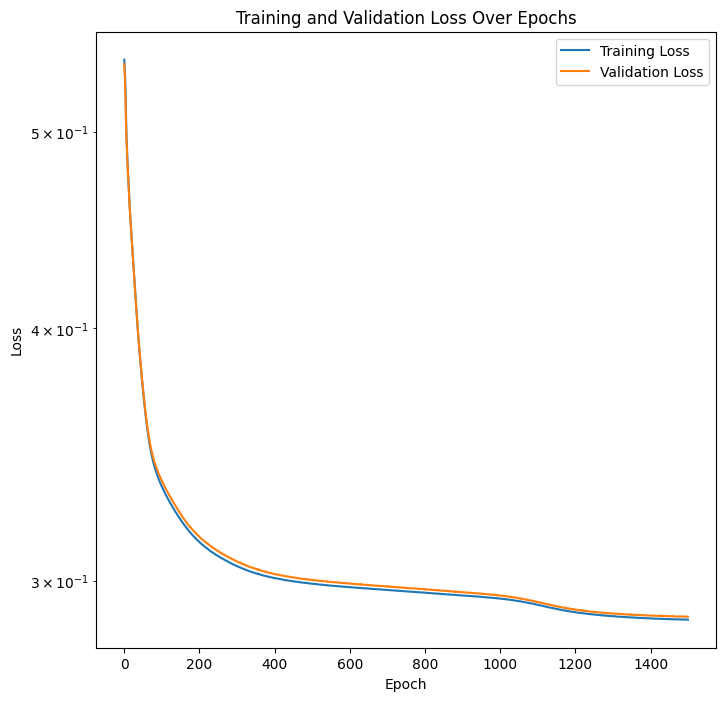

In [180]:
epochs_range = range(epochs)

# Plotting
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
#plt.xlim([1,epochs])
#plt.ylim([0,2])
plt.semilogy()
plt.show()

In [188]:
import numpy as np
import estimator

new_data = pd.read_csv("C:\Projects\Crosstalk\Machine_Learning\Data/2024-09-05_14-55/test.csv")
first_line = new_data.iloc[15]
correct_output = first_line[output_keys].array

input_data = {key: np.array([first_line[key]]) for key in inputs}
predictions = model.predict(input_data)
print("Predicted values: ", predictions[0])
print("Correct values: ", correct_output)
print("the mean squared error is: ", np.linalg.norm(predictions[0] - correct_output) ** 2)
error = estimator.percent_error(predictions[0], correct_output)
print("The percent error is: ", error * 100)

parameters = {key: first_line[key] for key in input_keys}
print(parameters)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted values:  [ 0.60925096  0.60762167  0.6366116   0.7385786   0.7261518   0.5364983
  0.5405651   0.7319324  -0.00789839  0.00844979 -0.1754753  -0.12729967
  0.72550195 -0.01640368 -0.00578597  0.20115474  0.40421823  0.40113717
  0.01219076  0.04978742  0.02240224  0.01722529]
Correct values:  <PandasArray>
[            0.71336,              0.4192,             0.65296,
             0.74744,             0.92952,             0.63728,
             0.46904,             0.74168,            -0.59056,
            -0.64264,            -0.16192,             -0.1472,
             0.92784,            -0.42784,            -0.48648,
             0.20128,  0.3282398872357129,  0.0923867376245052,
  1.2366318984348703,  0.8698146232047075, -0.2384655358219716,
 -0.5068562809753492]
Length: 22, dtype: float64
the mean squared error is:  3.9242069021307646
The percent error is:  127.24393094747077
{'decay_0': 0.3385567502983899, 'decay_1': 0.4881396638245

In [189]:
import tensorflow as tf

target_outputs = tf.constant(correct_output, dtype=tf.float32)  # Replace with your target values

# Initialize the input parameters as variables to optimize
initial_guess = {
    'decay_0': 0.5,
    'decay_1': 0.5,
    'W_0': 0,
    'W_1': 0,
    'J_0': 0
}
input_vars = {key: tf.Variable(value, dtype=tf.float32) for key, value in initial_guess.items()}


# Use the variables as inputs to the model
def model_loss(target):
    # Pass the variables through the model to get the predicted output
    model_inputs = {key: tf.expand_dims(input_vars[key], 0) for key in input_keys}
    predicted_outputs = model(model_inputs, training=False)

    # Calculate the loss between predicted and target outputs
    loss = tf.reduce_mean(tf.abs(predicted_outputs - target))
    return loss * 1000


# Set up the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Optimization loop
for step in range(300):  # Adjust the number of steps as needed
    with tf.GradientTape() as tape:
        loss = model_loss(target_outputs)
    # Compute the gradients of the loss with respect to the input variables
    grads = tape.gradient(loss, input_vars.values())
    # input_vars['J_0'].assign(-0.64)
    # Apply the gradients to the input variables
    optimizer.apply_gradients(zip(grads, input_vars.values()))

    # Print the loss and current input variables every 100 steps
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.numpy()}, Inputs: {[input_vars[key].numpy() for key in input_keys]}")

# Final optimized input parameters
optimized_inputs = {key: var.numpy() for key, var in input_vars.items()}
print("Optimized Inputs:", optimized_inputs)
print(parameters)

Step 0, Loss: 313.7186279296875, Inputs: [0.49000007, 0.5099998, 0.009999923, 0.009999931, -0.009999933]
Step 100, Loss: 283.5638427734375, Inputs: [0.321322, 0.44878635, 0.2612131, 0.27821043, -0.59903115]
Step 200, Loss: 283.3408203125, Inputs: [0.3209291, 0.4474852, 0.26336724, 0.2790787, -0.6029598]
Optimized Inputs: {'decay_0': 0.3203789, 'decay_1': 0.44580993, 'W_0': 0.26002544, 'W_1': 0.27874523, 'J_0': -0.6056155}
{'decay_0': 0.3385567502983899, 'decay_1': 0.4881396638245256, 'W_0': 0.2401736419926808, 'W_1': 0.3096126947082128, 'J_0': -0.5881311322718885}


In [191]:


print(list(optimized_inputs.values()))
print(list(parameters.values()))

error = estimator.percent_error(np.array(list(optimized_inputs.values())), np.array(list(parameters.values())))
print(error * 100)

[0.3203789, 0.44580993, 0.26002544, 0.27874523, -0.6056155]
[0.3385567502983899, 0.4881396638245256, 0.2401736419926808, 0.3096126947082128, -0.5881311322718885]
7.190681342321792


In [192]:
errors = []
for i in range(10):
    line = new_data.iloc[i]
    correct_output = line[output_keys].array
    parameters = {key: line[key] for key in input_keys}
    input_vars = {key: tf.Variable(value, dtype=tf.float32) for key, value in initial_guess.items()}
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)


    def model_loss(target):
        # Pass the variables through the model to get the predicted output
        model_inputs = {key: tf.expand_dims(input_vars[key], 0) for key in input_keys}
        predicted_outputs = model(model_inputs, training=False)

        # Calculate the loss between predicted and target outputs
        loss = tf.reduce_mean(tf.abs(predicted_outputs - target))
        return loss


    for step in range(500):  # Adjust the number of steps as needed
        with tf.GradientTape() as tape:
            loss = model_loss(correct_output)

        # Compute the gradients of the loss with respect to the input variables
        grads = tape.gradient(loss, input_vars.values())

        # Apply the gradients to the input variables
        optimizer.apply_gradients(zip(grads, input_vars.values()))

        # Print the loss and current input variables every 100 steps
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.numpy()}, Inputs: {[input_vars[key].numpy() for key in input_keys]}")
            print(np.array(list(parameters.values())))

    optimized_inputs = {key: var.numpy() for key, var in input_vars.items()}

    optimized_inputs = np.array(list(optimized_inputs.values()))
    parameters = np.array(list(parameters.values()))

    # optimized_inputs = optimized_inputs[:-1]
    # parameters = parameters[:-1]


    error = estimator.percent_error(optimized_inputs,parameters)
    errors.append(error)
    print("Error is: ", error * 100)
print("The mean percent error is: ", np.mean(errors) * 100)

Step 0, Loss: 0.33710402250289917, Inputs: [0.59999365, 0.4000951, -0.0999943, 0.09998842, -0.09998962]
[ 0.56130986  0.31298694 -1.01076092  1.55675042  0.31244982]
Step 100, Loss: 0.2493424415588379, Inputs: [0.51420885, 0.23822734, -1.0728618, 1.2809224, 0.3925895]
[ 0.56130986  0.31298694 -1.01076092  1.55675042  0.31244982]
Step 200, Loss: 0.24865196645259857, Inputs: [0.52702117, 0.22601393, -1.0606803, 1.264077, 0.36213458]
[ 0.56130986  0.31298694 -1.01076092  1.55675042  0.31244982]
Step 300, Loss: 0.2484048753976822, Inputs: [0.5449683, 0.23124817, -1.0300922, 1.3302926, 0.3035993]
[ 0.56130986  0.31298694 -1.01076092  1.55675042  0.31244982]
Step 400, Loss: 0.2483113408088684, Inputs: [0.52717435, 0.217561, -1.046369, 1.346109, 0.36613786]
[ 0.56130986  0.31298694 -1.01076092  1.55675042  0.31244982]
Error is:  21.715782345124786
Step 0, Loss: 0.4559907913208008, Inputs: [0.59999377, 0.5995527, -0.09999333, -0.09998662, -0.0999803]
[ 0.57011267  0.23190745 -0.77779781 -0.311

In [158]:
import numpy as np
import estimator

new_data = pd.read_csv("C:\Projects\Crosstalk\Machine_Learning\Data/2024-08-28_14-31/test.csv")
first_line = new_data.iloc[10]
correct_output = first_line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].array
#input_data = {key: [first_line[key]] for key in inputs}
input_data = {key: np.array([first_line[key]]) for key in inputs}
predictions = model.predict(input_data)
print("Predicted values: ", predictions[0][0])
print("Correct values: ", correct_output)
print("the mean squared error is: ", 0.3 * np.linalg.norm(predictions[0] - correct_output) ** 2)
error = estimator.percent_error(predictions[0], correct_output)
print("The percent error is: ", error * 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted values:  0.25585717
Correct values:  <PandasArray>
[ 1.109304248656438, 0.1669449844863293,  1.361796655829442,
  1.612846174712094, -0.643076477415179]
Length: 5, dtype: float64


ValueError: operands could not be broadcast together with shapes (8,) (5,) 

In [118]:
error = []
for i in range(len(new_data)):
    line = new_data.iloc[i]

    correct_output = line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].array

    input_data = {key: np.array([line[key]]) for key in inputs}
    predictions = model.predict(input_data)
    error.append(estimator.percent_error(predictions[0], correct_output))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [119]:
print("The mean percent error is: ", np.mean(error) * 100)

The mean percent error is:  56.559793507707965


In [125]:
error_dict = {key: [] for key in ['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]}

for i in range(len(new_data)):
    line = new_data.iloc[i]

    correct_output = line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].array

    input_data = {key: np.array([line[key]]) for key in inputs}
    predictions = model.predict(input_data)

    # Calculate the percent error for each output key and append it to the respective list
    for j, key in enumerate(error_dict.keys()):
        error_dict[key].append(estimator.percent_error(predictions[0][0][j], correct_output[j]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [126]:
import pandas as pd

# Convert the error dictionary to a DataFrame
error_df = pd.DataFrame(error_dict)

# Calculate the mean of each error
mean_errors = error_df.mean()

# Display the results
for key, value in mean_errors.items():
    print(f"The mean error for {key} is: {value * 100} precent")

print("total error is: ", mean_errors.mean() * 100)

The mean error for decay_0 is: 21.14048892259431 precent
The mean error for decay_1 is: 29.513848007879584 precent
The mean error for W_0 is: 408.22536167818157 precent
The mean error for W_1 is: 32.036623575115335 precent
The mean error for J_0 is: 8072.218115692011 precent
total error is:  1712.6268875751566


In [13]:

print(custom_loss(predictions[0], correct_output))
a = custom_loss(predictions[0], correct_output)

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:Mul] name: 